### Importing Necessary Libraries

In [1]:
import os
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, BatchNormalization
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_recall_fscore_support as score

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [2]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]

In [3]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})

In [4]:
train_labels = pd.read_csv('./Data/train_labels_1.csv')
test_labels = pd.read_csv('./Data/test_labels_1.csv')

In [5]:
roi_info = np.load('./Data/ROI-Extractions/train/train_roi_viz.npy')

In [6]:
roi_info.shape

(16000, 100, 6)

## Data Preparation

In [53]:
BATCH_SIZE = 50
checkpnt_each = 100
assert checkpnt_each % BATCH_SIZE == 0
checkpnt_i = checkpnt_each // BATCH_SIZE
FEATURE_DIM = 2048

In [20]:
# roi_count = [np.sum([roi[-1]==1 for roi in doc]) for doc in roi_info] # RoIs per document Image

In [21]:
# fine_tune_data = list()
# for i in range(16000 // (BATCH_SIZE*checkpnt_i)):
#     k = 0
#     batch_data = np.load(f'./Data/ResNet-kP-train-precompute/train_data_precomp-{i+1}.npy')
#     batch_roi = roi_count[(i*(BATCH_SIZE*checkpnt_i)):((i+1)*(BATCH_SIZE*checkpnt_i))]
#     for j in range(BATCH_SIZE*checkpnt_i):
#         fine_tune_data.append(np.concatenate([batch_data[k:(k+batch_roi[j])], np.zeros((100-batch_roi[j], FEATURE_DIM))])[np.newaxis,:])
#         k += batch_roi[j]
# fine_tune_data = np.concatenate(fine_tune_data)
# fine_tune_data.shape

(16000, 100, 2048)

In [22]:
# np.save(f'./Data/ResNet-kP-train-precompute/whole_train_data_precomp.npy', fine_tune_data)

In [23]:
# fine_tune_data = np.load(f'./Data/ResNet-kP-train-precompute/whole_train_data_precomp.npy')
# fine_tune_data.shape

(16000, 100, 2048)

In [24]:
# fine_tune_data = np.squeeze(np.mean(fine_tune_data, axis=1, keepdims=True))
# fine_tune_data.shape

(16000, 2048)

In [25]:
# fine_tune_data_4P = np.load('./Data/ResNet-4P-train-precompute/whole_train_data_precomp.npy')
# fine_tune_data_4P = np.reshape(fine_tune_data_4P, (16000, -1))
# fine_tune_data_4P.shape

(16000, 10240)

In [26]:
# fine_tune_data = np.concatenate([fine_tune_data, fine_tune_data_4P], axis=-1)
# fine_tune_data.shape

(16000, 12288)

In [27]:
# np.save(f'./Data/ResNet-kP-train-precompute/whole_train_data_precomp_roi_n_4p.npy', fine_tune_data)

In [28]:
fine_tune_data = np.load(f'./Data/ResNet-kP-train-precompute/whole_train_data_precomp_roi_n_4p.npy')

In [29]:
fine_tune_data.shape

(16000, 12288)

In [30]:
fine_tune_labels = labels['label'].to_numpy()
fine_tune_labels.shape

(16000,)

In [31]:
fine_tune_data_train = fine_tune_data[list(train_labels['id'])]
fine_tune_data_train.shape

(15200, 12288)

In [32]:
fine_tune_labels_train = train_labels['label'].to_numpy()
fine_tune_labels_train.shape

(15200,)

In [33]:
fine_tune_data_test = fine_tune_data[list(test_labels['id'])]
fine_tune_data_test.shape

(800, 12288)

In [34]:
fine_tune_labels_test = test_labels['label'].to_numpy()
fine_tune_labels_test.shape

(800,)

### Validation Data

In [35]:
validation_data = pd.DataFrame({'images':['./Data/validation/validation/'+name for name in os.listdir('./Data/validation/validation/')]})
validation_data['id'] = [name.split('.')[0] for name in os.listdir('./Data/validation/validation/')]
validation_data['label'] = -1 # Simply added to prevent re-writing code
validation_data.sort_values(by=['id'], inplace=True)
validation_data

,images,id,label
850,./Data/validation/validation/17801.tif,17801,-1
898,./Data/validation/validation/17802.tif,17802,-1
852,./Data/validation/validation/17803.tif,17803,-1
798,./Data/validation/validation/17804.tif,17804,-1
750,./Data/validation/validation/17805.tif,17805,-1
...,...,...,...
246,./Data/validation/validation/18696.tif,18696,-1
211,./Data/validation/validation/18697.tif,18697,-1
760,./Data/validation/validation/18698.tif,18698,-1
787,./Data/validation/validation/18699.tif,18699,-1


In [36]:
roi_info_validation = np.load('./Data/ROI-Extractions/validation/validation_roi_viz.npy')
roi_info_validation.shape

(900, 100, 6)

In [38]:
# roi_count_validation = [np.sum([roi[-1]==1 for roi in doc]) for doc in roi_info_validation] # RoIs per document Image

In [42]:
# fine_tune_data_validation = list()
# for i in range(900 // (BATCH_SIZE*checkpnt_i)):
#     k = 0
#     batch_data = np.load(f'./Data/ResNet-kP-validation-precompute/validation_data_precomp-{i+1}.npy')
#     batch_roi = roi_count_validation[(i*(BATCH_SIZE*checkpnt_i)):((i+1)*(BATCH_SIZE*checkpnt_i))]
#     for j in range(BATCH_SIZE*checkpnt_i):
#         fine_tune_data_validation.append(np.concatenate([batch_data[k:(k+batch_roi[j])], np.zeros((100-batch_roi[j], 2048))])[np.newaxis,:])
#         k += batch_roi[j]
# fine_tune_data_validation = np.concatenate(fine_tune_data_validation)
# fine_tune_data_validation.shape

(900, 100, 2048)

In [43]:
# np.save(f'./Data/ResNet-kP-validation-precompute/whole_validation_data_precomp.npy', fine_tune_data_validation)

In [45]:
# fine_tune_data_validation = np.load(f'./Data/ResNet-kP-validation-precompute/whole_validation_data_precomp.npy')
# fine_tune_data_validation.shape

(900, 100, 2048)

In [46]:
# fine_tune_data_validation = np.squeeze(np.mean(fine_tune_data_validation, axis=1, keepdims=True))
# fine_tune_data_validation.shape

(900, 2048)

In [47]:
# fine_tune_data_4P_validation = np.load('./Data/ResNet-4P-validation-precompute/whole_validation_data_precomp.npy')
# fine_tune_data_4P_validation = np.reshape(fine_tune_data_4P_validation, (900, -1))
# fine_tune_data_4P_validation.shape

(900, 10240)

In [48]:
# fine_tune_data_validation = np.concatenate([fine_tune_data_validation, fine_tune_data_4P_validation], axis=-1)
# fine_tune_data_validation.shape

(900, 12288)

In [49]:
# np.save(f'./Data/ResNet-kP-validation-precompute/whole_validation_data_precomp_roi_n_4p.npy', fine_tune_data_validation)

In [50]:
fine_tune_data_validation = np.load(f'./Data/ResNet-kP-validation-precompute/whole_validation_data_precomp_roi_n_4p.npy')

In [52]:
fine_tune_data_validation.shape

(900, 12288)

## Fine-Tuning Models

The fine-tuning part of our model.

In [56]:
def ftmodel():
    inputs = Input(shape=(6*FEATURE_DIM))
    x = Flatten()(inputs)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.3
    # x = Dropout(top_dropout_rate, name='top_dropout_1')(x)
    # x = Dense(1024, name='top_dense_1', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_2')(x)
    x = Dense(512, name='top_dense_2', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(16, activation='softmax', name='pred', kernel_regularizer=l2(5e-5))(x)

    model1 = tf.keras.Model(inputs, outputs, name='ResNet-FineTune')
    return model1

In [57]:
model1 = ftmodel()
model1.summary()

Model: "ResNet-FineTune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12288)]           0         
                                                                 
 flatten_1 (Flatten)         (None, 12288)             0         
                                                                 
 batch_normalization_1 (Batc  (None, 12288)            49152     
 hNormalization)                                                 
                                                                 
 top_dropout_2 (Dropout)     (None, 12288)             0         
                                                                 
 top_dense_2 (Dense)         (None, 512)               6291968   
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                   

### Model Training

The fine-tuning will be done on the ResNet's $2048D$ representation vectors for $5$ pieces of the image and the averaged ROI representation vectors.

In [58]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [59]:
EPOCHS = 1000
checkpoint_filepaths = ['./Models/ResNet-kP/auto-ResNet-FT-model-weight']
model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = "loss",
    mode='min',
    save_best_only=True) for checkpoint_filepath in checkpoint_filepaths]

In [60]:
history = model1.fit(fine_tune_data_train, fine_tune_labels_train, epochs=EPOCHS, batch_size=800, validation_data=(fine_tune_data_test, fine_tune_labels_test), validation_batch_size=800, callbacks=[model_checkpoint_callback])
# history = model1.fit(fine_tune_data, fine_tune_labels, epochs=EPOCHS, batch_size=1600, callbacks=[model_checkpoint_callback])
model1.save_weights("./Models/ResNet-kP/resnet-kp-model-weights")
model1.load_weights('./Models/ResNet-kP/resnet-kp-model-weights')

Epoch 1/1000


2022-10-08 15:51:10.182097: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-08 15:51:10.435493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/19 [=========================>....] - ETA: 0s - loss: 1.8058 - accuracy: 0.5202

2022-10-08 15:51:11.131918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 1s 41ms/step - loss: 1.7605 - accuracy: 0.5316 - val_loss: 1.8321 - val_accuracy: 0.4737
Epoch 2/1000
19/19 [==============================] - 0s 26ms/step - loss: 0.9927 - accuracy: 0.7281 - val_loss: 1.6909 - val_accuracy: 0.5813
Epoch 3/1000
19/19 [==============================] - 1s 31ms/step - loss: 0.7502 - accuracy: 0.7974 - val_loss: 1.6302 - val_accuracy: 0.6187
Epoch 4/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.6015 - accuracy: 0.8418 - val_loss: 1.5687 - val_accuracy: 0.6350
Epoch 5/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.4836 - accuracy: 0.8775 - val_loss: 1.5396 - val_accuracy: 0.6350
Epoch 6/1000
19/19 [==============================] - 1s 27ms/step - loss: 0.3912 - accuracy: 0.9104 - val_loss: 1.4995 - val_accuracy: 0.6413
Epoch 7/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.3237 - accuracy: 0.9305 - val_loss: 1.4629 - val_accuracy: 0.6250
Epoch 8/1000

19/19 [==============================] - 1s 28ms/step - loss: 0.0477 - accuracy: 0.9993 - val_loss: 1.0126 - val_accuracy: 0.7713
Epoch 59/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0481 - accuracy: 0.9995 - val_loss: 0.9944 - val_accuracy: 0.7750
Epoch 60/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.0474 - accuracy: 0.9993 - val_loss: 1.0144 - val_accuracy: 0.7688
Epoch 61/1000
19/19 [==============================] - 1s 27ms/step - loss: 0.0473 - accuracy: 0.9993 - val_loss: 1.0097 - val_accuracy: 0.7700
Epoch 62/1000
19/19 [==============================] - 1s 27ms/step - loss: 0.0461 - accuracy: 0.9995 - val_loss: 1.0306 - val_accuracy: 0.7612
Epoch 63/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0468 - accuracy: 0.9996 - val_loss: 0.9986 - val_accuracy: 0.7713
Epoch 64/1000
19/19 [==============================] - 1s 27ms/step - loss: 0.0460 - accuracy: 0.9993 - val_loss: 0.9876 - val_accuracy: 0.7637
Epoch 

Epoch 115/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0421 - accuracy: 0.9982 - val_loss: 1.1161 - val_accuracy: 0.7625
Epoch 116/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0442 - accuracy: 0.9978 - val_loss: 1.1267 - val_accuracy: 0.7550
Epoch 117/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0441 - accuracy: 0.9980 - val_loss: 1.1559 - val_accuracy: 0.7512
Epoch 118/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0480 - accuracy: 0.9966 - val_loss: 1.1764 - val_accuracy: 0.7600
Epoch 119/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0506 - accuracy: 0.9958 - val_loss: 1.2288 - val_accuracy: 0.7300
Epoch 120/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0546 - accuracy: 0.9949 - val_loss: 1.2288 - val_accuracy: 0.7450
Epoch 121/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0573 - accuracy: 0.9942 - val_loss: 1.1576 - val_ac

19/19 [==============================] - 0s 16ms/step - loss: 0.0363 - accuracy: 0.9993 - val_loss: 1.1919 - val_accuracy: 0.7875
Epoch 228/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0356 - accuracy: 0.9993 - val_loss: 1.2190 - val_accuracy: 0.7812
Epoch 229/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0354 - accuracy: 0.9995 - val_loss: 1.2138 - val_accuracy: 0.7763
Epoch 230/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0343 - accuracy: 0.9996 - val_loss: 1.1779 - val_accuracy: 0.7738
Epoch 231/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0340 - accuracy: 0.9997 - val_loss: 1.1866 - val_accuracy: 0.7763
Epoch 232/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0331 - accuracy: 0.9998 - val_loss: 1.1698 - val_accuracy: 0.7850
Epoch 233/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0329 - accuracy: 0.9997 - val_loss: 1.1763 - val_accuracy: 0.7763


19/19 [==============================] - 0s 16ms/step - loss: 0.0295 - accuracy: 0.9997 - val_loss: 1.1056 - val_accuracy: 0.7775
Epoch 340/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0302 - accuracy: 0.9995 - val_loss: 1.1483 - val_accuracy: 0.7788
Epoch 341/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0294 - accuracy: 0.9995 - val_loss: 1.2266 - val_accuracy: 0.7650
Epoch 342/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0302 - accuracy: 0.9991 - val_loss: 1.1557 - val_accuracy: 0.7700
Epoch 343/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0330 - accuracy: 0.9984 - val_loss: 1.1531 - val_accuracy: 0.7750
Epoch 344/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0345 - accuracy: 0.9981 - val_loss: 1.1401 - val_accuracy: 0.7688
Epoch 345/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0383 - accuracy: 0.9979 - val_loss: 1.2612 - val_accuracy: 0.7550


19/19 [==============================] - 0s 15ms/step - loss: 0.0537 - accuracy: 0.9938 - val_loss: 1.4371 - val_accuracy: 0.7475
Epoch 452/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0530 - accuracy: 0.9945 - val_loss: 1.3564 - val_accuracy: 0.7475
Epoch 453/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0526 - accuracy: 0.9945 - val_loss: 1.3516 - val_accuracy: 0.7575
Epoch 454/1000
19/19 [==============================] - 0s 18ms/step - loss: 0.0505 - accuracy: 0.9961 - val_loss: 1.3313 - val_accuracy: 0.7612
Epoch 455/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0466 - accuracy: 0.9978 - val_loss: 1.2541 - val_accuracy: 0.7763
Epoch 456/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0433 - accuracy: 0.9986 - val_loss: 1.2331 - val_accuracy: 0.7688
Epoch 457/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0426 - accuracy: 0.9986 - val_loss: 1.1963 - val_accuracy: 0.7837


19/19 [==============================] - 0s 16ms/step - loss: 0.0407 - accuracy: 0.9993 - val_loss: 1.1464 - val_accuracy: 0.7625
Epoch 564/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0405 - accuracy: 0.9991 - val_loss: 1.1802 - val_accuracy: 0.7637
Epoch 565/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0396 - accuracy: 0.9993 - val_loss: 1.1842 - val_accuracy: 0.7750
Epoch 566/1000
19/19 [==============================] - 0s 18ms/step - loss: 0.0381 - accuracy: 0.9996 - val_loss: 1.1527 - val_accuracy: 0.7775
Epoch 567/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0374 - accuracy: 0.9995 - val_loss: 1.1972 - val_accuracy: 0.7662
Epoch 568/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0367 - accuracy: 0.9997 - val_loss: 1.1532 - val_accuracy: 0.7675
Epoch 569/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0360 - accuracy: 0.9997 - val_loss: 1.1511 - val_accuracy: 0.7812


19/19 [==============================] - 0s 17ms/step - loss: 0.0319 - accuracy: 0.9980 - val_loss: 1.2827 - val_accuracy: 0.7500
Epoch 676/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0342 - accuracy: 0.9977 - val_loss: 1.2856 - val_accuracy: 0.7537
Epoch 677/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0365 - accuracy: 0.9969 - val_loss: 1.3492 - val_accuracy: 0.7475
Epoch 678/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0429 - accuracy: 0.9955 - val_loss: 1.3501 - val_accuracy: 0.7500
Epoch 679/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0452 - accuracy: 0.9953 - val_loss: 1.4012 - val_accuracy: 0.7450
Epoch 680/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0486 - accuracy: 0.9956 - val_loss: 1.4136 - val_accuracy: 0.7387
Epoch 681/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0432 - accuracy: 0.9964 - val_loss: 1.2867 - val_accuracy: 0.7500


19/19 [==============================] - 0s 18ms/step - loss: 0.0248 - accuracy: 0.9995 - val_loss: 1.1257 - val_accuracy: 0.7763
Epoch 788/1000
19/19 [==============================] - 0s 18ms/step - loss: 0.0251 - accuracy: 0.9996 - val_loss: 1.1072 - val_accuracy: 0.7662
Epoch 789/1000
19/19 [==============================] - 0s 18ms/step - loss: 0.0242 - accuracy: 0.9997 - val_loss: 1.1172 - val_accuracy: 0.7688
Epoch 790/1000
19/19 [==============================] - 0s 18ms/step - loss: 0.0239 - accuracy: 0.9998 - val_loss: 1.0901 - val_accuracy: 0.7675
Epoch 791/1000
19/19 [==============================] - 0s 19ms/step - loss: 0.0235 - accuracy: 0.9997 - val_loss: 1.0703 - val_accuracy: 0.7688
Epoch 792/1000
19/19 [==============================] - 0s 19ms/step - loss: 0.0238 - accuracy: 0.9997 - val_loss: 1.1219 - val_accuracy: 0.7612
Epoch 793/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.0246 - accuracy: 0.9992 - val_loss: 1.1405 - val_accuracy: 0.7688


19/19 [==============================] - 0s 19ms/step - loss: 0.0271 - accuracy: 0.9995 - val_loss: 1.1642 - val_accuracy: 0.7850
Epoch 900/1000
19/19 [==============================] - 0s 19ms/step - loss: 0.0290 - accuracy: 0.9988 - val_loss: 1.1854 - val_accuracy: 0.7750
Epoch 901/1000
19/19 [==============================] - 0s 19ms/step - loss: 0.0300 - accuracy: 0.9988 - val_loss: 1.1855 - val_accuracy: 0.7725
Epoch 902/1000
19/19 [==============================] - 0s 19ms/step - loss: 0.0303 - accuracy: 0.9986 - val_loss: 1.2117 - val_accuracy: 0.7650
Epoch 903/1000
19/19 [==============================] - 0s 19ms/step - loss: 0.0305 - accuracy: 0.9985 - val_loss: 1.2543 - val_accuracy: 0.7650
Epoch 904/1000
19/19 [==============================] - 0s 19ms/step - loss: 0.0302 - accuracy: 0.9988 - val_loss: 1.2463 - val_accuracy: 0.7688
Epoch 905/1000
19/19 [==============================] - 0s 19ms/step - loss: 0.0311 - accuracy: 0.9986 - val_loss: 1.2216 - val_accuracy: 0.7662


In [61]:
def plot_train_loss(history, model_name):  
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model_name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train loss', 'train accuracy', 'val loss', 'val accuracy'], loc='upper left')

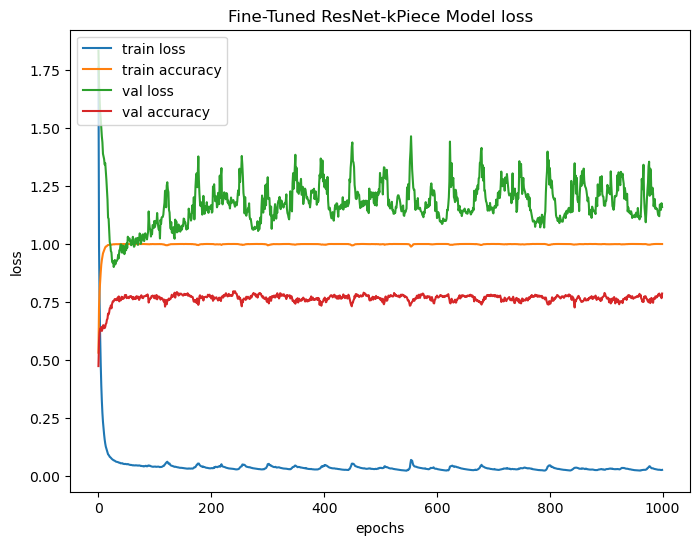

In [62]:
plot_train_loss(history, 'Fine-Tuned ResNet-kPiece Model')

### Model Evaluation

#### On Train Data

Now, after the model is being trained, we will look at the performance of the model on the training set.

In [63]:
train_preds = model1.predict(fine_tune_data_train)

 56/475 [==>...........................] - ETA: 1s

2022-10-08 15:57:13.418176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


475/475 [==============================] - 2s 4ms/step


In [64]:
train_pred_labels = np.argmax(train_preds, axis=-1)

In [65]:
train_pred_labels

array([ 1, 13, 13, ...,  3,  9,  9])

In [66]:
np.sum(train_pred_labels == train_labels['label'])

15193

Looking at the misclassified images to get a better idea about what features the model is unable to capture.

In [67]:
mis_train_data = train_labels[train_pred_labels != train_labels['label']]
mis_train_data

,id,images,label
3597,3781,./Data/train/train/3781.tif,0
4633,4876,./Data/train/train/4876.tif,12
5298,5578,./Data/train/train/5578.tif,11
7417,7807,./Data/train/train/7807.tif,11
12255,12896,./Data/train/train/12896.tif,9
12916,13599,./Data/train/train/13599.tif,5
14569,15333,./Data/train/train/15333.tif,7


In [68]:
precision, recall, fscore, support = score(train_labels['label'], train_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,1.000000,0.998978,0.999488,978
1,0.995694,1.000000,0.997843,925
2,1.000000,1.000000,1.000000,925
3,1.000000,1.000000,1.000000,947
4,0.998926,1.000000,0.999463,930
5,1.000000,0.998960,0.999480,962
6,1.000000,1.000000,1.000000,998
7,1.000000,0.998905,0.999452,913
8,1.000000,1.000000,1.000000,1005
9,1.000000,0.998951,0.999475,953


#### On Train-Test Data

In [69]:
test_preds = model1.predict(fine_tune_data_test)

25/25 [==============================] - 0s 3ms/step


In [70]:
test_pred_labels = np.argmax(test_preds, axis=-1)

In [71]:
test_pred_labels

array([11,  8,  6, 11, 14,  9, 13,  4, 14,  1,  6, 15, 10, 14,  1, 11,  0,
        9,  6,  1,  8, 14,  3, 12,  6,  0,  3,  3,  3,  3, 11,  1,  6,  2,
        1,  8,  4,  5,  1,  9,  6, 12, 14,  2,  5, 14,  3,  0, 13,  4,  0,
       10, 12,  0, 11, 14, 15,  6,  9,  2, 15, 13,  2, 11,  7, 12,  8,  0,
        6,  3,  4,  4, 12,  0,  8,  6,  7,  0, 12, 11, 11,  0, 12, 12,  9,
        8,  1, 13,  0, 13, 10, 11,  4, 10,  1,  7, 11,  8, 13, 10,  3, 11,
        5,  9,  7, 14,  8,  2,  1,  8,  7,  5,  9,  4, 12, 14, 12, 10, 11,
        6, 13,  1,  0, 12, 13,  5, 10,  8,  0, 11,  3, 11,  6,  1,  6,  9,
       14, 10,  7, 14, 10,  8,  4, 12,  8,  5,  8,  9,  2, 13, 15,  5,  4,
       14,  4,  9,  4, 14,  7,  7,  8,  4,  4, 12, 13,  8, 15,  3,  8,  8,
       13,  6,  3, 11,  7, 12, 10, 14, 14,  8,  6, 11, 13, 11,  6, 13,  4,
       14, 11,  7, 15,  0,  3,  0, 10, 13,  5, 10, 11, 11, 15,  1,  9,  1,
        9,  5, 13, 12, 12,  1,  4,  8, 11,  6, 13,  5,  4, 12,  8,  0,  9,
       13, 15,  0,  7, 10

In [72]:
np.sum(test_pred_labels == test_labels['label'])

629

In [73]:
mis_train_data = test_labels[test_pred_labels != test_labels['label']]
mis_train_data

,id,images,label
3,41,./Data/train/train/41.tif,1
7,100,./Data/train/train/100.tif,10
12,179,./Data/train/train/179.tif,7
19,372,./Data/train/train/372.tif,13
20,378,./Data/train/train/378.tif,12
...,...,...,...
776,15528,./Data/train/train/15528.tif,5
779,15568,./Data/train/train/15568.tif,9
780,15571,./Data/train/train/15571.tif,14
782,15582,./Data/train/train/15582.tif,3


In [74]:
precision, recall, fscore, support = score(test_labels['label'], test_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.741379,0.796296,0.767857,54
1,0.551724,0.727273,0.627451,44
2,0.897436,0.813953,0.853659,43
3,0.840000,0.913043,0.875000,46
4,0.850000,0.944444,0.894737,36
5,0.704545,0.620000,0.659574,50
6,0.851064,0.869565,0.860215,46
7,0.800000,0.769231,0.784314,52
8,0.841270,0.981481,0.905983,54
9,0.869565,0.851064,0.860215,47


In [75]:
np.mean(fscore)

0.787085876889608

#### On Validation Data

Generating Predictions for the Validation Set

In [76]:
valid_preds = model1.predict(fine_tune_data_validation)

29/29 [==============================] - 0s 4ms/step


2022-10-08 15:57:39.999356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [77]:
valid_pred_labels = np.argmax(valid_preds, axis=-1)

In [78]:
valid_pred_labels

array([ 4,  6,  4,  8,  3,  8, 11, 11,  2,  4,  0, 15, 14, 12, 13,  4, 11,
        1,  0,  5, 14,  9, 13,  6,  1,  2,  7,  3,  8,  1, 15, 14,  8, 10,
       14,  6, 11,  8,  6, 10,  4,  7, 12,  3,  2, 10,  3,  2,  6,  2, 10,
        0, 10,  7, 13,  9,  2,  3,  1, 10,  2, 13,  4,  5, 12,  8,  9,  7,
        8,  4,  5,  5,  4,  8,  4,  6,  4, 15, 11,  0,  9, 15, 13,  8,  7,
       12, 11, 10, 12, 10, 12,  0,  1, 12,  3,  4, 10, 10,  7,  4,  6, 11,
        1, 12,  7, 13, 15,  9, 10,  1,  7,  7, 11, 14,  2,  4,  1, 14,  1,
       11, 12,  5,  3,  6,  1,  1,  0,  9,  4, 12,  8,  1,  0,  9, 10,  3,
        0, 11, 13,  5,  6,  7,  2,  3,  0,  9,  9, 15,  1, 14, 10,  1, 13,
        8, 12, 10,  0,  7,  5, 14,  3,  1,  2, 10,  7,  5,  4,  4,  7,  9,
       12, 11,  4,  7,  4,  0, 11, 12,  0,  8,  9, 11,  3,  2,  3,  3,  7,
        8, 11,  2,  9, 12,  6,  2,  4,  9,  2,  9,  8,  7,  1,  3,  1,  0,
       15,  1,  4,  3,  4,  4, 11,  6,  6,  7,  4,  4, 13,  3, 10, 14,  1,
        6,  0,  8, 12,  2

### Submission

For Kaggle Submission

In [79]:
submission_data = pd.DataFrame({'id':list(range(17801, 18701))})
submission_data['label'] = valid_pred_labels
submission_data

,id,label
0,17801,4
1,17802,6
2,17803,4
3,17804,8
4,17805,3
...,...,...
895,18696,13
896,18697,12
897,18698,8
898,18699,5


In [80]:
submission_data.to_csv('./Submissions/submission-resnet-kPiece.csv', index=False)